In [1]:
from collections import Counter
import os

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
from pycaret.classification import *
import matplotlib.pyplot as plt
from sklearn.metrics import *
from sklearn.svm import SVC
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
SEP       = os.path.sep
ROOT_PATH = SEP.join(os.getcwd().split(SEP)[ :-3])
DATA_PATH = f'{ROOT_PATH}/Dataset/machine failure'

In [3]:
def draw_histplot(column, *dfs):
    
    fig, ax = plt.subplots(1, 3, figsize = (24, 7))
    for idx, (name, df_) in enumerate(zip(['total', 'normal', 'abnormal'], dfs)):
        
        sns.histplot(df_[column], kde = True, ax = ax[idx])
        ax[idx].set_title(f'{name} - {column} histplot')
        
        
    plt.show()
    

def draw_data_distribution(y_values):
    
    fig, ax = plt.subplots(1, 2, figsize = (15, 7))
    for idx, (dtype, y_value) in enumerate(zip(['train', 'valid'], y_values)):
        
        count = Counter(y_value)
        ax[idx].bar(count.keys(), count.values())
        for k, v in count.items():
            
            ax[idx].text(k, v, v,
                         va = 'bottom',
                         ha = 'center')
            ax[idx].set_title(f'{dtype} data distribution')
            
    plt.show()
    
    
def metrics_report(test_y, pred_y, dtype = 'train'):
    print(f'classification report for {dtype}\n{classification_report(test_y, pred_y)}')
    print(f'AUC score for {dtype} : {roc_auc_score(test_y, pred_y):.3f}')
    
    
def evaluation(model, method):
    
    os.makedirs('submissions', exist_ok = True)
    
    submission = pd.read_csv(f'{DATA_PATH}/sample_submission.csv')
    test_df    = pd.read_csv(f'{DATA_PATH}/test.csv')

    test_df.drop(['id', 'Product ID'], axis = 1, inplace = True)
    test_df['Type'] = le.fit_transform(test_df['Type'])
    test_df         = scaler.transform(test_df)

    pred_y = model.predict(test_df)

    submission['Machine failure'] = pred_y
    submission.to_csv(f'submissions/submission_{method}.csv', index = False)

In [4]:
df        = pd.read_csv(f'{DATA_PATH}/train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136429 entries, 0 to 136428
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       136429 non-null  int64  
 1   Product ID               136429 non-null  object 
 2   Type                     136429 non-null  object 
 3   Air temperature [K]      136429 non-null  float64
 4   Process temperature [K]  136429 non-null  float64
 5   Rotational speed [rpm]   136429 non-null  int64  
 6   Torque [Nm]              136429 non-null  float64
 7   Tool wear [min]          136429 non-null  int64  
 8   Machine failure          136429 non-null  int64  
 9   TWF                      136429 non-null  int64  
 10  HDF                      136429 non-null  int64  
 11  PWF                      136429 non-null  int64  
 12  OSF                      136429 non-null  int64  
 13  RNF                      136429 non-null  int64  
dtypes: f

In [5]:
normal   = df[df['Machine failure'] == 0]
abnormal = df[df['Machine failure'] == 1] 

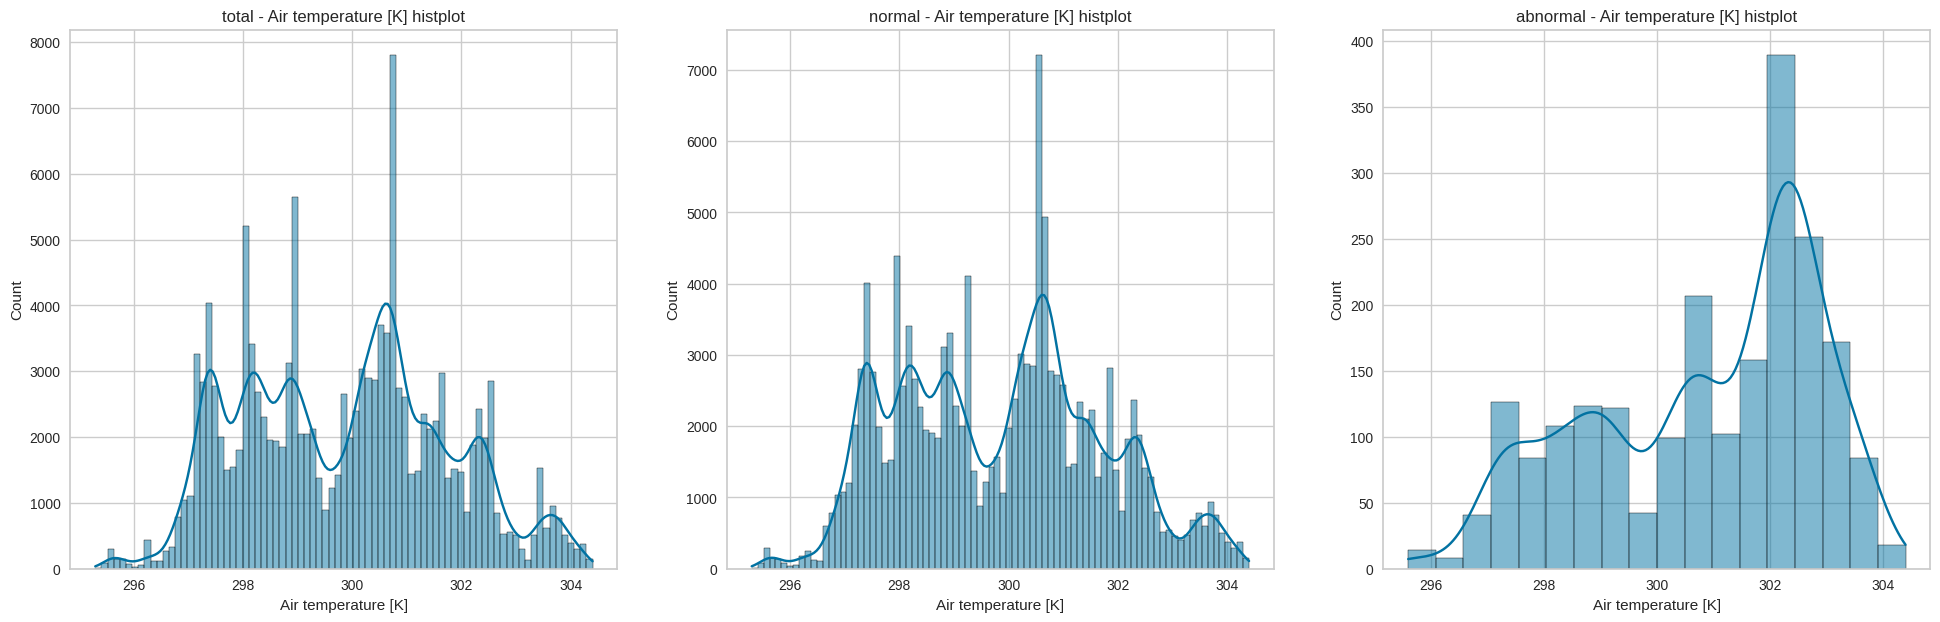

In [6]:
draw_histplot('Air temperature [K]', *[df, normal, abnormal])

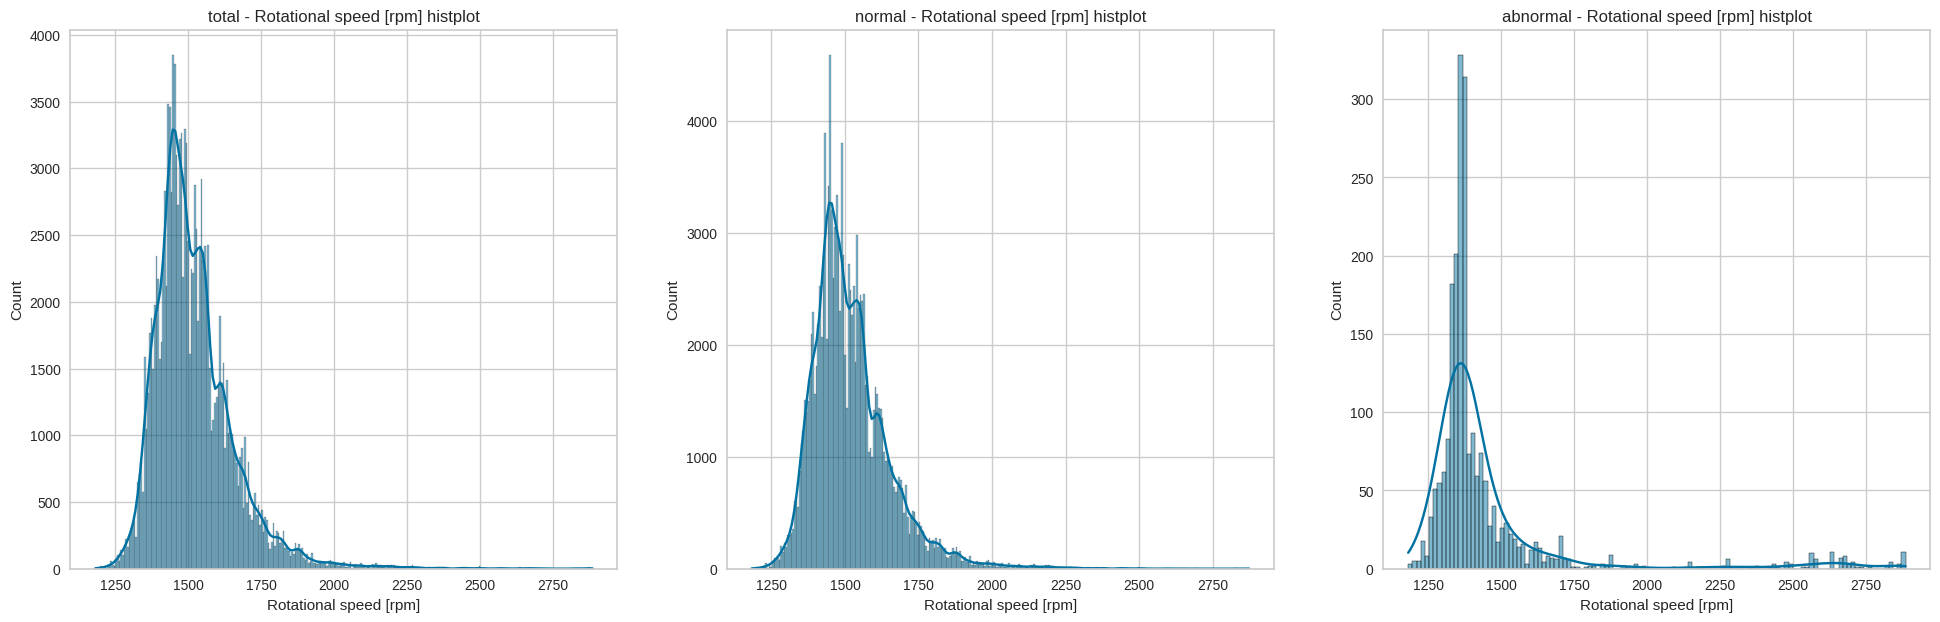

In [7]:
draw_histplot('Rotational speed [rpm]', *[df, normal, abnormal])

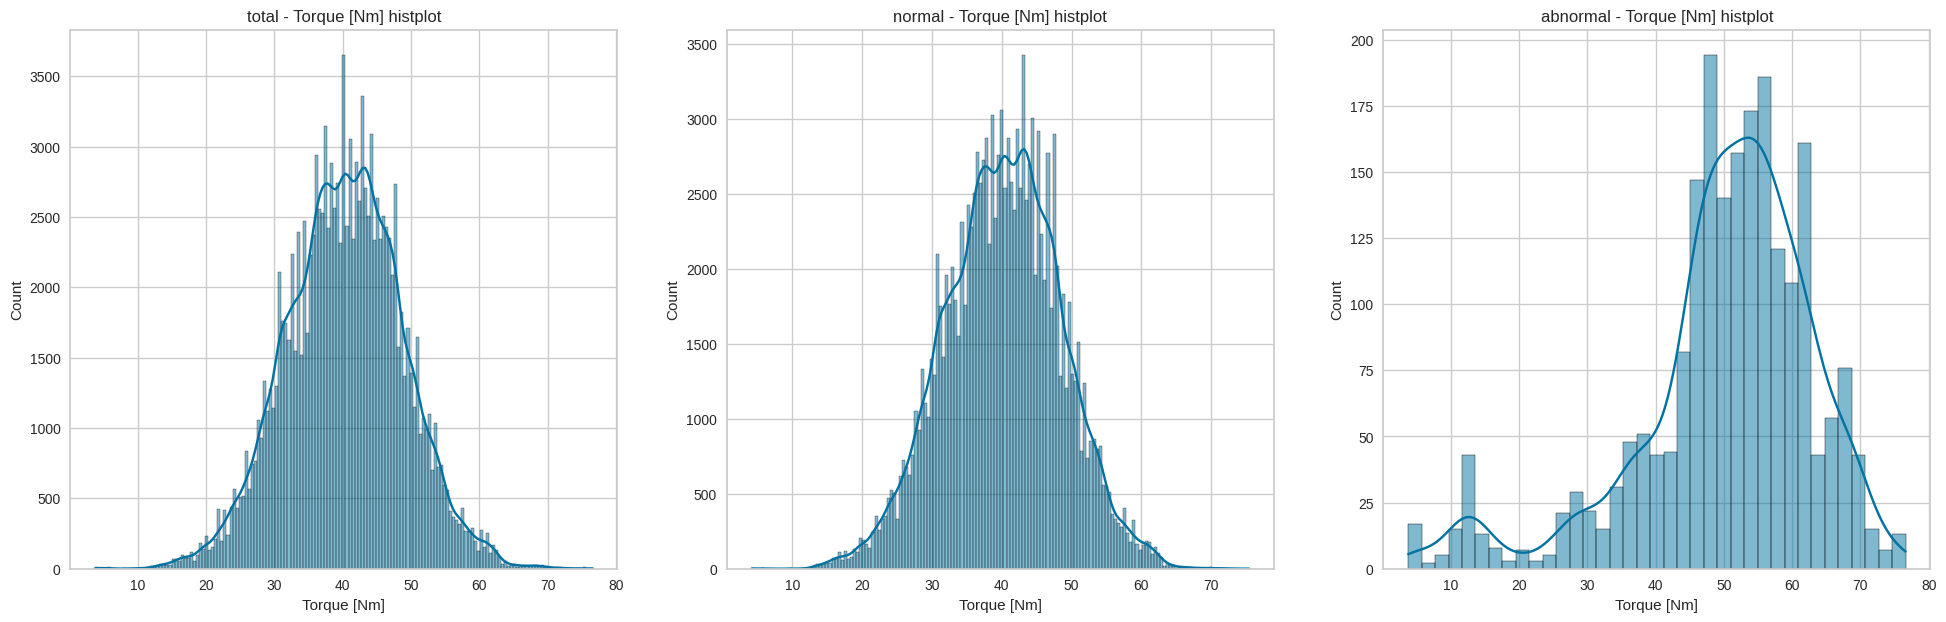

In [8]:
draw_histplot('Torque [Nm]', *[df, normal, abnormal])

In [9]:
le = LabelEncoder()
df['Type'] = le.fit_transform(df['Type'])
df.drop(['id', 'Product ID'], axis = 1, inplace = True)
df.head(3)

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,2,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,1,299.3,308.5,1805,26.5,25,0,0,0,0,0,0


In [10]:
X = df.drop('Machine failure', axis = 1)
y = df['Machine failure']

X.shape, y.shape, df.shape

((136429, 11), (136429,), (136429, 12))

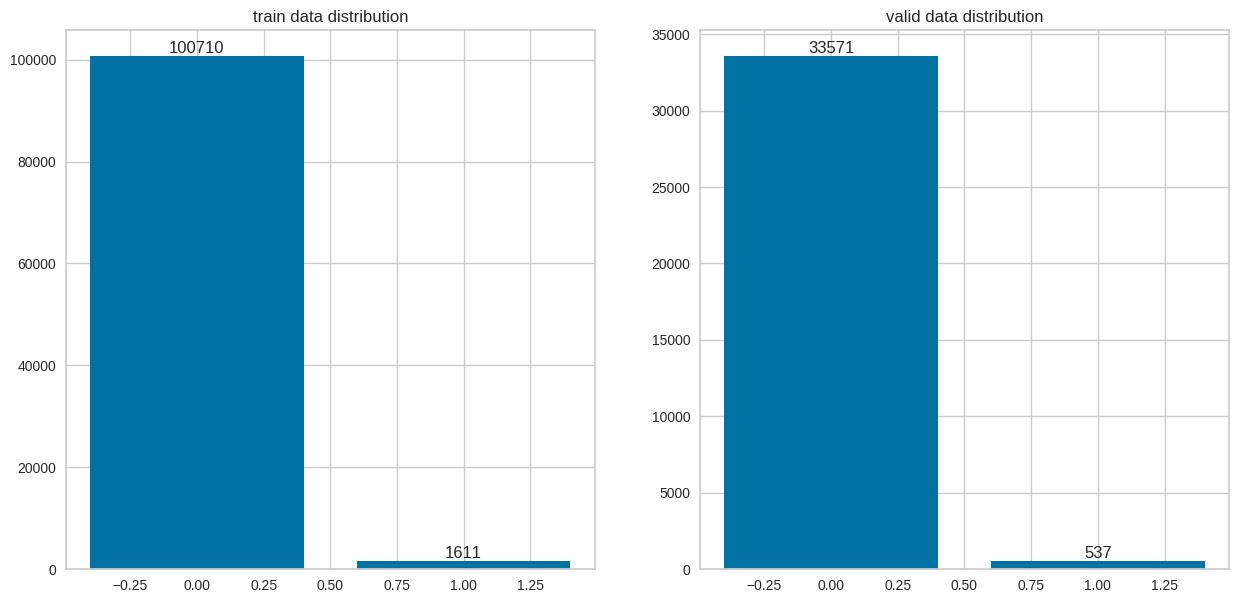

In [11]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.25, stratify = y,
                                                    random_state    =   99,  shuffle = True)

draw_data_distribution([train_y, test_y])

In [12]:
scaler  = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x  = scaler.transform(test_x)

In [13]:
svm = SVC()
svm.fit(train_x, train_y)

SVC()

In [14]:
pred_y = svm.predict(train_x)
metrics_report(pred_y, train_y, dtype = 'train')

classification report for train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101086
           1       0.76      0.99      0.86      1235

    accuracy                           1.00    102321
   macro avg       0.88      0.99      0.93    102321
weighted avg       1.00      1.00      1.00    102321

AUC score for train : 0.994


In [15]:
pred_y = svm.predict(test_x)
metrics_report(pred_y, test_y, dtype = 'test')

evaluation(svm, 'SVC_no_SMOTE')

classification report for test
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     33689
           1       0.77      0.99      0.87       419

    accuracy                           1.00     34108
   macro avg       0.89      0.99      0.93     34108
weighted avg       1.00      1.00      1.00     34108

AUC score for test : 0.993


In [16]:
sampler          = SMOTE(random_state = 99)
train_x, train_y = sampler.fit_resample(train_x, train_y) 

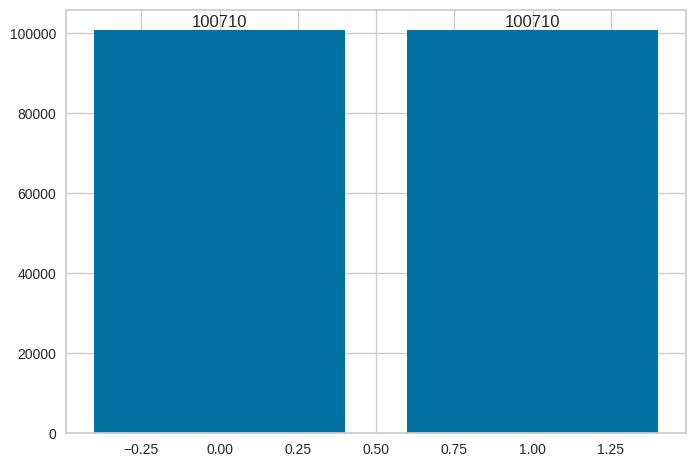

In [17]:
count = Counter(train_y)
plt.bar(count.keys(), count.values())
for k, v in count.items():

    plt.text(k, v, v,
                 va = 'bottom',
                 ha = 'center')

In [18]:
svm = SVC()
svm.fit(train_x, train_y)

SVC()

In [19]:
pred_y = svm.predict(train_x)
metrics_report(pred_y, train_y)

classification report for train
              precision    recall  f1-score   support

           0       0.98      0.85      0.91    116462
           1       0.83      0.98      0.90     84958

    accuracy                           0.90    201420
   macro avg       0.90      0.91      0.90    201420
weighted avg       0.92      0.90      0.91    201420

AUC score for train : 0.915


In [20]:
pred_y = svm.predict(test_x)
metrics_report(pred_y, test_y, dtype = 'test')

evaluation(svm, 'SVC_SMOTE')

classification report for test
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     33093
           1       0.83      0.44      0.57      1015

    accuracy                           0.98     34108
   macro avg       0.91      0.72      0.78     34108
weighted avg       0.98      0.98      0.98     34108

AUC score for test : 0.718


In [21]:
model = GradientBoostingClassifier(random_state = 99)
model.fit(train_x, train_y)

GradientBoostingClassifier(random_state=99)

In [22]:
pred_y = model.predict(train_x)
metrics_report(pred_y, train_y)

classification report for train
              precision    recall  f1-score   support

           0       0.96      0.89      0.92    108643
           1       0.88      0.96      0.92     92777

    accuracy                           0.92    201420
   macro avg       0.92      0.92      0.92    201420
weighted avg       0.93      0.92      0.92    201420

AUC score for train : 0.925


In [23]:
pred_y = model.predict(test_x)
metrics_report(pred_y, test_y, dtype = 'test')

evaluation(model, 'GBM')

classification report for test
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     32391
           1       0.86      0.27      0.41      1717

    accuracy                           0.96     34108
   macro avg       0.91      0.63      0.69     34108
weighted avg       0.96      0.96      0.95     34108

AUC score for test : 0.633


In [24]:
model     = CatBoostClassifier(iterations  = 100, loss_function = 'CrossEntropy', 
                           random_seed     = 99, learning_rate = 0.3, verbose = False)
model.fit(train_x, train_y,
          eval_set = (test_x, test_y)
          )

In [25]:
pred_y = model.predict(train_x)
metrics_report(pred_y, train_y, dtype = 'train')

classification report for train
              precision    recall  f1-score   support

           0       0.99      0.95      0.97    105093
           1       0.94      0.99      0.97     96327

    accuracy                           0.97    201420
   macro avg       0.97      0.97      0.97    201420
weighted avg       0.97      0.97      0.97    201420

AUC score for train : 0.968


In [26]:
pred_y = model.predict(test_x)
metrics_report(pred_y, test_y, dtype = 'test')

evaluation(model, 'CatBoosting')

classification report for test
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     33279
           1       0.82      0.53      0.65       829

    accuracy                           0.99     34108
   macro avg       0.91      0.77      0.82     34108
weighted avg       0.98      0.99      0.98     34108

AUC score for test : 0.766


In [27]:
setup_clf = setup(data = df       , target = 'Machine failure', 
                  train_size = 0.8, fold = 10, 
                  fix_imbalance = True, fix_imbalance_method = "tomeklinks")

,Description,Value
0,Session id,4750
1,Target,Machine failure
2,Target type,Binary
3,Original data shape,"(136429, 12)"
4,Transformed data shape,"(135873, 12)"
5,Transformed train set shape,"(108587, 12)"
6,Transformed test set shape,"(27286, 12)"
7,Numeric features,11
8,Preprocess,True
9,Imputation type,simple


In [28]:
best_model = compare_models(sort = 'AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9961,0.9641,0.7765,0.9666,0.8608,0.8589,0.8643,0.2850
gbc,Gradient Boosting Classifier,0.9963,0.9604,0.7811,0.9761,0.8674,0.8655,0.8713,1.0820
ada,Ada Boost Classifier,0.9963,0.9597,0.7782,0.9860,0.8695,0.8676,0.8741,0.4400
catboost,CatBoost Classifier,0.9961,0.9577,0.7759,0.9725,0.8627,0.8607,0.8666,29.8820
nb,Naive Bayes,0.9943,0.9485,0.7788,0.8530,0.8126,0.8098,0.8114,0.2370
rf,Random Forest Classifier,0.9961,0.9421,0.7776,0.9688,0.8624,0.8604,0.8660,0.4570
et,Extra Trees Classifier,0.9961,0.9396,0.7788,0.9640,0.8611,0.8592,0.8644,0.4480
lr,Logistic Regression,0.9963,0.9385,0.7672,0.9938,0.8655,0.8637,0.8713,1.0960
lda,Linear Discriminant Analysis,0.9964,0.9359,0.7724,0.9947,0.8692,0.8674,0.8747,0.2580
dt,Decision Tree Classifier,0.9922,0.8923,0.7864,0.7345,0.7593,0.7553,0.7559,0.2650


In [29]:
model       = create_model('lda')
tuned_model = tune_model(model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9972,0.9465,0.8198,1.0000,0.9010,0.8995,0.9041
1,0.9960,0.9329,0.7442,1.0000,0.8533,0.8513,0.8609
2,0.9958,0.9178,0.7384,0.9922,0.8467,0.8446,0.8541
3,0.9965,0.9230,0.7778,1.0000,0.8750,0.8733,0.8804
4,0.9961,0.9390,0.7544,0.9923,0.8571,0.8552,0.8635
5,0.9964,0.9399,0.7733,1.0000,0.8721,0.8703,0.8778
6,0.9954,0.9315,0.7209,0.9841,0.8322,0.8299,0.8403
7,0.9970,0.9523,0.8081,1.0000,0.8939,0.8924,0.8976
8,0.9972,0.9547,0.8256,0.9930,0.9016,0.9002,0.9041


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9963,0.9395,0.7674,1.0000,0.8684,0.8666,0.8744
1,0.9949,0.9174,0.6744,1.0000,0.8056,0.8031,0.8191
2,0.9944,0.9105,0.6512,0.9912,0.7860,0.7833,0.8011
3,0.9958,0.8965,0.7310,1.0000,0.8446,0.8425,0.8532
4,0.9950,0.9396,0.6842,0.9915,0.8097,0.8072,0.8215
5,0.9944,0.9115,0.6453,1.0000,0.7845,0.7818,0.8011
6,0.9940,0.9007,0.6279,0.9818,0.7660,0.7630,0.7827
7,0.9960,0.9444,0.7442,1.0000,0.8533,0.8513,0.8609
8,0.9951,0.9199,0.6919,0.9917,0.8151,0.8126,0.8262


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


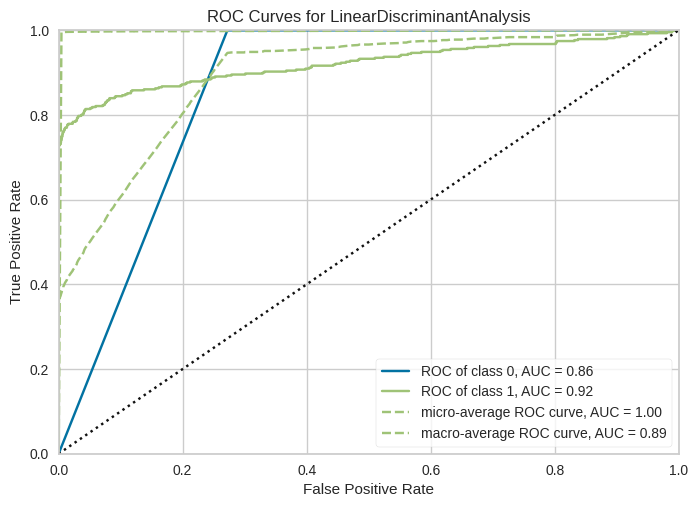

In [30]:
plot_model(tuned_model)

In [31]:
submission = pd.read_csv(f'{DATA_PATH}/sample_submission.csv')
test_df    = pd.read_csv(f'{DATA_PATH}/test.csv')

test_df.drop(['id', 'Product ID'], axis = 1, inplace = True)
test_df['Type'] = le.fit_transform(test_df['Type'])

In [32]:
final_model = finalize_model(tuned_model)
prediction  = predict_model(final_model, test_df)

In [33]:
submission['Machine failure'] = prediction['prediction_label']
submission.to_csv(f'submissions/submission_pycaret.csv', index = False)